In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle
from collections import deque

import torch
import torch.nn as nn
from torch import optim

sys.path.append("..")
from src.utils import load_and_process_digits
from src.models import LogisticRegressionTorch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

    
def simple_loader(inputs, targets, batch_size=128, shuffle_per_iteration=20):
    index = 0
    while True:
        indexes_get = np.arange(index * batch_size, (index + 1) * batch_size) % len(inputs)
        x_ = np.take(inputs, indexes_get, axis=0)
        y_ = np.take(targets, indexes_get, axis=0)
        
        index += 1
        if index % shuffle_per_iteration == 0:
            full_index = np.arange(len(x_))
            shuffle(full_index)
            inputs = np.take(inputs, full_index, axis=0)
            targets = np.take(targets, full_index, axis=0)
        yield x_, y_
    
def train_digits(config: dict):
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_and_process_digits()
    train_loader = simple_loader(x_train, y_train, batch_size=config["batch_size"])
    
    model = LogisticRegressionTorch(input_dim=x_train.shape[-1], output_dim=10)
    
    optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()
    
    train_losses, valid_losses = [], []
    bst_loss = 1e+4
    patient_counter = 0
    for i_epoch in range(config["num_epochs"]):
        loss_record = deque(maxlen=100)
        for i_iter in range(len(x_train) // config["batch_size"]):
            x, y = next(train_loader)

            logits = model(torch.from_numpy(x))
            loss_train = loss_fn(logits, torch.from_numpy(y))
            
            ### Do regularization
            if config["l1_alpha"] > 0:
                l1_term = torch.tensor(0.)
                for model_params in model.parameters():
                    reg = torch.abs(model_params).sum()
                    l1_term += reg
                loss_train = loss_train + config["l1_alpha"] * l1_term
                
            if config["l2_alpha"] > 0:
                l2_term = torch.tensor(0.)
                for model_params in model.parameters():
                    reg = torch.norm(model_params)
                    l2_term += reg
                loss_train = loss_train + config["l2_alpha"] * l2_term

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            loss_record.append(loss_train.detach().cpu().numpy())
            
        with torch.no_grad():
            yp_logits = model(torch.from_numpy(x_valid))
            loss_valid = loss_fn(yp_logits, torch.from_numpy(y_valid))
            loss_valid = loss_valid.detach().cpu().numpy()
        
        print("Epoch: {}/{}, Training Loss: {:.3f}, Validation Loss: {:.3f}".format(
            str(i_epoch + 1).zfill(4),
            config["num_epochs"],
            np.mean(loss_record),
            loss_valid
        ), flush=True, end="\r")
        train_losses.append(np.mean(loss_record))
        valid_losses.append(loss_valid)
        
        ### Do earlystopping
        if patient_counter >= config["n_earlystopping_rounds"]:
            return model, train_losses, valid_losses
        
        if loss_valid < bst_loss:
            bst_loss = loss_valid
            patient_counter = 0
        else:
            patient_counter += 1
        
    return model, train_losses, valid_losses

In [2]:
from dataclasses import dataclass, asdict

@dataclass
class TrainConfig:
    batch_size: int
    learning_rate: float
    num_epochs: int = 500
    l1_alpha: float = 0.
    l2_alpha: float = 0.
    n_earlystopping_rounds: int = 1e+8
        
    def to_dict(self):
        return asdict(self)
        
train_config = TrainConfig(
    batch_size=64, 
    learning_rate=0.9,
    num_epochs=1000,
#     l1_alpha=0.001
    l2_alpha=0.01,
    n_earlystopping_rounds=10
)

In [3]:
model, train_losses, valid_losses = train_digits(config=train_config.to_dict())

In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_and_process_digits()

In [5]:
y_pred = model(torch.from_numpy(x_train))
y_pred = y_pred.detach().numpy()

In [6]:
from src.utils import get_result_metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_train, y_pred=y_pred.argmax(axis=-1))
cm

array([[150,   0,   0,   0,   1,   2,   0,   0,   0,   0],
       [  0, 124,  19,   1,   0,   1,   1,   0,   8,   0],
       [  1,  10, 107,  19,   0,   0,   0,   4,   1,   0],
       [  0,   1,   0, 133,   0,   1,   0,   5,   2,   0],
       [  5,  20,   0,   0, 100,   0,   4,   2,   3,   0],
       [  0,   1,   0,   1,   0, 143,   0,   0,   0,   3],
       [  7,   0,   0,   0,   0,   0, 132,   0,   6,   0],
       [  0,   6,   0,   0,   4,   3,   0, 133,   3,   0],
       [  0,  17,   2,  10,   0,  10,   0,   2, 107,   0],
       [  2,  18,   0,  58,   0,  11,   0,   1,   3,  47]])

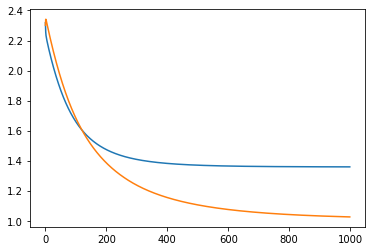

In [7]:
plt.plot(range(len(train_losses)), train_losses, label="train")
plt.plot(range(len(valid_losses)), valid_losses, label="valid")

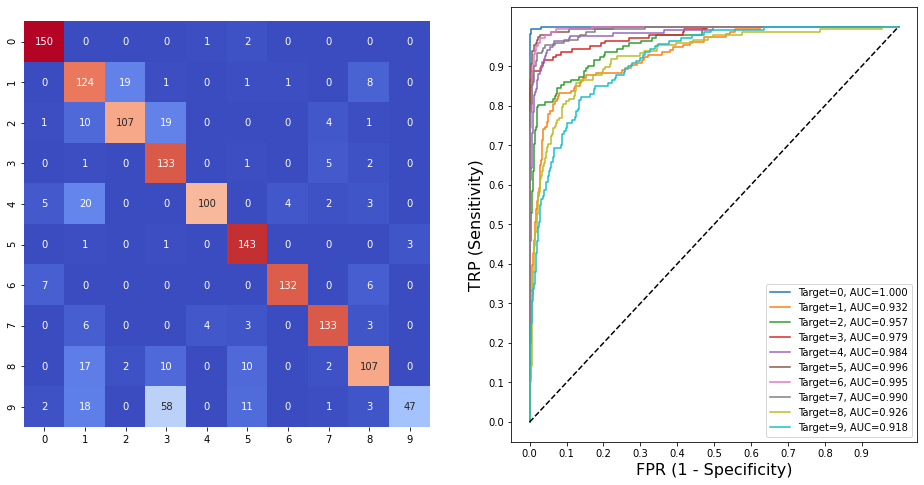

In [8]:
n_classes = 10
y_pred = model(torch.from_numpy(x_train)).detach().cpu().numpy()
cm = confusion_matrix(y_train, y_pred.argmax(axis=1))

plt.figure(figsize=(16, 8))
plt.subplot(121)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap="coolwarm")

plt.subplot(122)
results = {}
for i_class in range(n_classes):
    cls_result = get_result_metrics(
        y_true=y_train==i_class,
        y_score=y_pred[:, i_class],
        score_threshold=1./n_classes
    )
    results[i_class] = cls_result
    plt.plot(cls_result["fpr"], cls_result["tpr"], label="Target={}, AUC={:.3f}".format(i_class, cls_result["auc"]))

plt.xlabel("FPR (1 - Specificity)", fontsize=16)
plt.ylabel("TRP (Sensitivity)", fontsize=16)
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

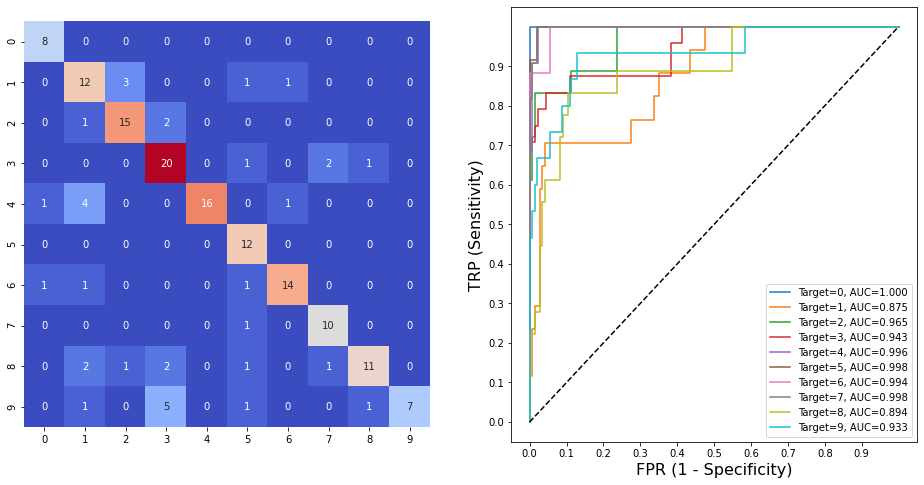

In [9]:
n_classes = 10
y_pred = model(torch.from_numpy(x_valid)).detach().cpu().numpy()
cm = confusion_matrix(y_valid, y_pred.argmax(axis=1))

plt.figure(figsize=(16, 8))
plt.subplot(121)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap="coolwarm")

plt.subplot(122)
results = {}
for i_class in range(n_classes):
    cls_result = get_result_metrics(
        y_true=y_valid==i_class,
        y_score=y_pred[:, i_class],
        score_threshold=1./n_classes
    )
    results[i_class] = cls_result
    plt.plot(cls_result["fpr"], cls_result["tpr"], label="Target={}, AUC={:.3f}".format(i_class, cls_result["auc"]))

plt.xlabel("FPR (1 - Specificity)", fontsize=16)
plt.ylabel("TRP (Sensitivity)", fontsize=16)
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

In [10]:
## Confidence Interval estimation
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

n_samples = 1000  # For AUC, larger than sample size is useless, but it doesn't matter
n_boots = 1000
cls_id = 1

bootstrap_result = []
for i_boot in tqdm(range(n_boots)):
    take_indexes = np.random.choice(np.arange(len(x_valid)), size=n_samples, replace=True)  # Sampling w/ replacement
    x_ = np.take(x_valid, take_indexes, axis=0)
    y_ = np.take(y_valid, take_indexes, axis=0)

    y_pred = model(torch.from_numpy(x_)).detach().cpu().numpy()
    this_auc_score = roc_auc_score(y_true=(y_==cls_id), y_score=y_pred[:,cls_id])
    bootstrap_result.append(this_auc_score)
    
# 95% Confidence Interval -- 2.5% to 97.5%
bootstrap_result = np.sort(bootstrap_result)

index_low = int(n_boots * 0.025)
index_center = int(n_boots * 0.50)
index_high = int(n_boots * 0.975)

ci_low = bootstrap_result[index_low]
ci_mean = bootstrap_result[index_center]
ci_high = bootstrap_result[index_high]

print("AUC of class={}, {:.3f} ({:.3f} - {:.3f})".format(cls_id, ci_mean, ci_low, ci_high))

100%|██████████| 1000/1000 [00:02<00:00, 403.89it/s]

AUC of class=1, 0.875 (0.843 - 0.907)
